## Decision Tree Regression on XRP Price Data

This notebook explores the use of **decision tree regression** to model short-term price behavior in XRP, a leading cryptocurrency.

Our primary goal is to predict the **current-period closing price** based on **lagged market indicators** from previous time steps. This ensures that predictions use only information available prior to the target variable — preserving a realistic, time-aware forecasting structure.

### Key Workflow Elements:
- Data preparation with lagged features and standardized inputs
- Training a baseline decision tree with depth limitation
- Applying **cost-complexity pruning** to improve generalization and control overfitting
- Evaluating performance using **mean squared error (MSE)**, **root MSE (RMSE)**, and **coefficient of determination (R²)**
- Comparing performance across a train/test split and **block walk-forward cross-validation**, which respects the sequential nature of the time series by training on past data and predicting future blocks step by step.

This notebook demonstrates that, with careful preprocessing, pruning, and time-respecting validation, even a single decision tree can achieve **practical short-term forecasting accuracy** — serving as a robust benchmark and a foundation for more advanced ensemble or deep learning models.

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text

# Model Evaluation & Training
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Loading the XRP Sample Dataset

We begin by loading the XRP sample dataset. Both the `Open time` and `Close time` columns are parsed as datetime objects.

This ensures we can later perform time-based operations (e.g., plotting, feature engineering with lags, resampling, or computing time deltas) without encountering formatting issues.

In [2]:
df = pd.read_csv("xrpdata_2025_sample.csv", parse_dates=['Open time', 'Close time'])

### 📈 Exploratory Time Series Plot

Before modeling, we visualize the closing prices from our **2025 sample** to inspect recent market behavior. This line plot confirms that our observations follow a consistent chronological order and provides a clear sense of the price dynamics we aim to forecast.

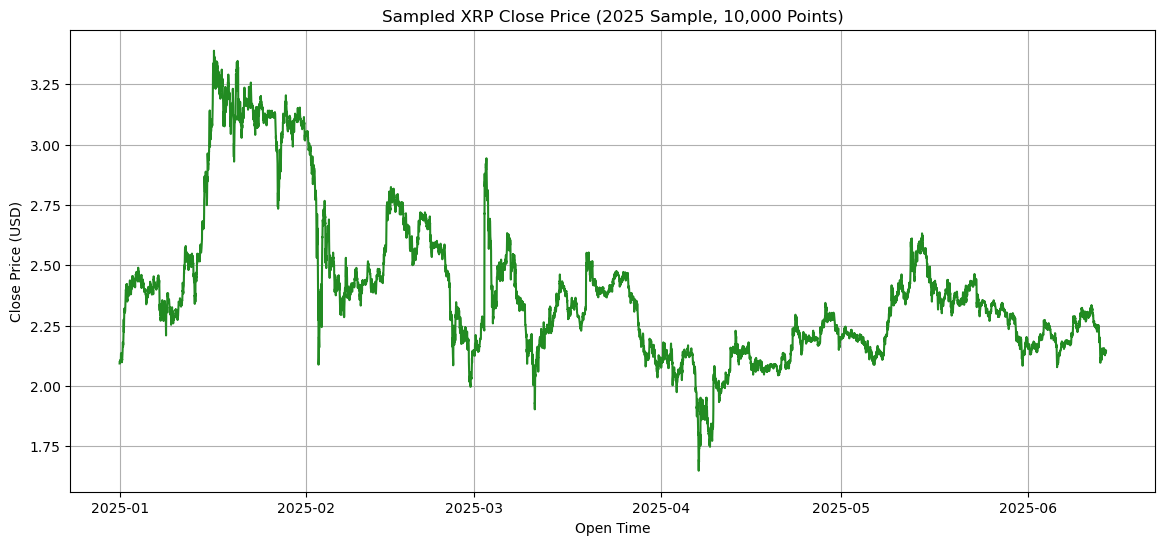

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df['Open time'], df['Close'], color='forestgreen')
plt.title('Sampled XRP Close Price (2025 Sample, 10,000 Points)')
plt.xlabel('Open Time')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

### Feature Engineering and Preprocessing for Regression

To model short-term XRP price behavior, we construct a time-aware regression dataset using lagged features.

- **Temporal ordering** is preserved by sorting rows chronologically by `Close time`
- **Lagged predictors** are created from the previous time step (t−1), including `Open`, `High`, `Low`, and `Close` prices
- We retain `Close time num`, a numeric timestamp feature representing the current period
- The target variable is the **current-period `Close`** price

To ensure the model is trained without future information leakage, we drop rows with missing lagged values and apply **z-score normalization** to all input features.

This prepares a strict, forecasting-safe dataset ready for training regression decision trees.

In [4]:
# Step 1: Load and clean data
df = pd.read_csv("xrpdata_sample.csv", parse_dates=['Open time', 'Close time'])

# Drop the 'Ignore' column if it exists
if 'Ignore' in df.columns:
    df = df.drop(columns=['Ignore'])

# Step 2: Sort by time to preserve temporal integrity
df = df.sort_values(by='Close time')

# Step 3: Create lagged features (t-1)
df['lag_Close'] = df['Close'].shift(1)
df['lag_Open']  = df['Open'].shift(1)
df['lag_High']  = df['High'].shift(1)
df['lag_Low']   = df['Low'].shift(1)

# Step 4: Drop rows with missing lag values
df_strict = df.dropna().copy()

# Step 5: Define predictors and response
features = ['lag_Close', 'lag_Open', 'lag_High', 'lag_Low', 'Close time num']
X_strict = df_strict[features]
y_strict = df_strict['Close']  # Current-period close is what we try to predict

# Step 6: Scale predictors
scaler = StandardScaler()
X_strict_scaled = scaler.fit_transform(X_strict)

# Optionally store mean and std for later usage
scaler_means = scaler.mean_
scaler_stds = scaler.scale_

print("Dataset ready: standardized predictors, no temporal leakage.")

Dataset ready: standardized predictors, no temporal leakage.


### Baseline Train-Test Split and Model Fitting

To establish a quick performance benchmark, we split the standardized dataset into training and testing sets using an 80/20 ratio while maintaining the original temporal order. 

We then fit a **decision tree regressor** with a maximum depth of 5 and evaluate its performance using **mean squared error (MSE)**, **root mean squared error (RMSE)**, and the **coefficient of determination (R²)**.

This baseline provides an initial sense of model fit before applying more robust, time-aware validation.

In [5]:
# Train-test split on scaled predictors
X_train_strict, X_test_strict, y_train_strict, y_test_strict = train_test_split(
    X_strict_scaled, y_strict, test_size=0.2, random_state=12
)

# Train decision tree on standardized inputs
tree_strict = DecisionTreeRegressor(max_depth=5, random_state=12)
tree_strict.fit(X_train_strict, y_train_strict)

# Make predictions and evaluate
y_pred_strict = tree_strict.predict(X_test_strict)
mse_strict = mean_squared_error(y_test_strict, y_pred_strict)
r2_strict = r2_score(y_test_strict, y_pred_strict)

# Report results
print("Decision Tree Performance (Max Depth = 5):")
print(f" - MSE: {mse_strict:.4f}")
print(f" - RMSE: {mse_strict**0.5:.4f}")
print(f" - R²: {r2_strict:.4f}")

Strict Decision Tree Performance:
 - MSE: 0.0008
 - RMSE: 0.0289
 - R²: 0.9958


### Initial Decision Tree Regression Results (Max Depth = 5)

We trained a decision tree regressor with a maximum depth of 5 using the lagged features dataset. The model was evaluated on a hold-out test set (20% of the data) after scaling the predictors.

#### Performance Metrics (Baseline):

- **Mean Squared Error (MSE):** 0.0008  
- **Root Mean Squared Error (RMSE):** 0.0289  
- **R² (Coefficient of Determination):** 0.9958

These results suggest the model fits the data extremely well, with minimal residual error and an R² near 1, indicating that over 99% of the variance in the test data is explained by the model.

#### A Note of Caution:

While these metrics appear outstanding, such high performance may indicate:
- Possible **overfitting**, even with a restricted tree depth
- A highly **predictable target** (e.g., close prices can follow smooth trends)
- Or potential **data leakage**, although our lagged-feature structure was designed to avoid this

To address this, we next apply **walk-forward cross-validation** for a more realistic, time-aware estimate of true predictive performance.

### Visualizing a Simplified Decision Tree

To better understand the decision logic of our model, we retrain a shallower tree with a maximum depth of 3 purely for visualization. 

This plot reveals how the model uses lagged price features and timestamps to predict the current closing price, highlighting key splits and leaf predictions.

Interpreting this simpler tree helps us verify that the splits align with domain expectations and provides insight into which features drive the model's decisions.

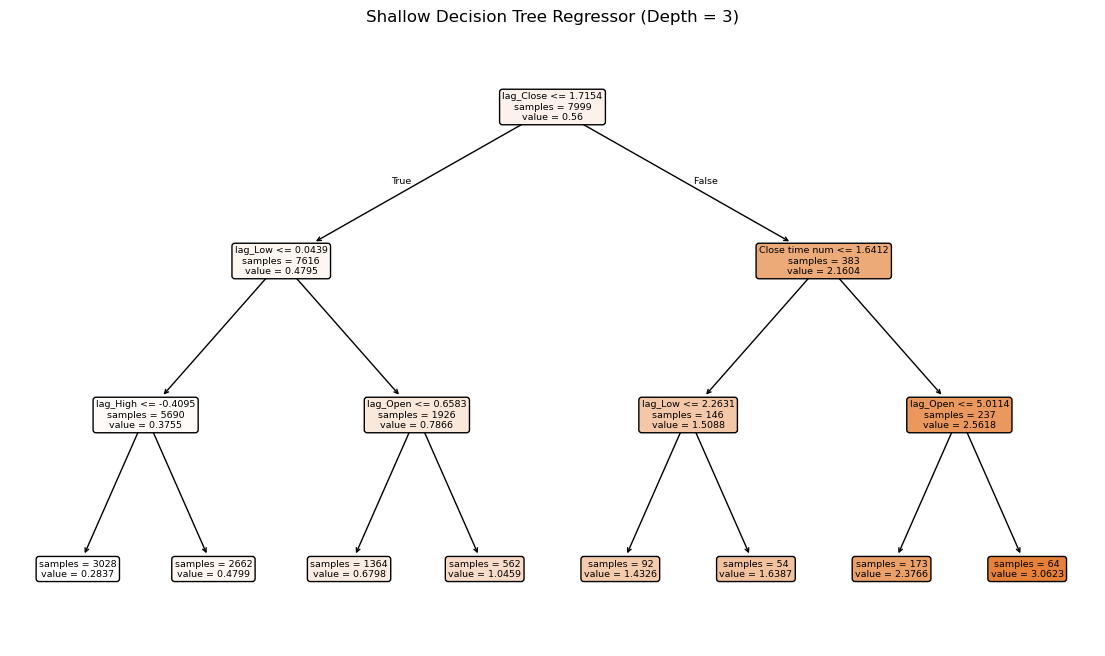

In [6]:
# Retrain a shallow tree (depth = 3) for visualization only
viz_tree = DecisionTreeRegressor(max_depth=3, random_state=12)
viz_tree.fit(X_train_strict, y_train_strict)

# Plot the shallower tree
plt.figure(figsize=(14, 8))
plot_tree(viz_tree,
          feature_names=features,
          filled=True,
          rounded=True,
          impurity=False,
          precision=4)
plt.title("Shallow Decision Tree Regressor (Depth = 3)")
plt.show()

### Walk-Forward Cross-Validation

To properly validate the decision tree on time series data, we apply **walk-forward cross-validation** instead of standard k-fold splits. 

This approach trains the model on an expanding window of past observations and tests it on the next unseen time step, repeating this process sequentially. 

This method prevents any information leakage from the future and provides a more realistic estimate of how well the model might perform in live forecasting scenarios.

In [7]:
# Block-style Walk-Forward Cross-Validation for Decision Tree

initial_train_size = int(0.6 * len(X_strict_scaled))
test_size = int(0.05 * len(X_strict_scaled))
step_size = test_size

rmse_scores_dt = []
r2_scores_dt = []

for start in range(initial_train_size, len(X_strict_scaled) - test_size, step_size):
    end = start + test_size

    X_train_wf = X_strict_scaled[:start]
    y_train_wf = y_strict.iloc[:start]
    X_test_wf = X_strict_scaled[start:end]
    y_test_wf = y_strict.iloc[start:end]

    tree_wf = DecisionTreeRegressor(max_depth=5, random_state=12)
    tree_wf.fit(X_train_wf, y_train_wf)

    y_pred_wf = tree_wf.predict(X_test_wf)

    rmse = mean_squared_error(y_test_wf, y_pred_wf) ** 0.5
    r2 = r2_score(y_test_wf, y_pred_wf)

    rmse_scores_dt.append(rmse)
    r2_scores_dt.append(r2)

print(f"Block Walk-Forward CV completed with {len(r2_scores_dt)} folds")
print(f"Average RMSE: {np.mean(rmse_scores_dt):.4f}")
print(f"Average R²: {np.mean(r2_scores_dt):.4f}")

Block Walk-Forward CV completed with 8 folds
Average RMSE: 0.1116
Average R²: 0.8417


### Block Walk-Forward Cross-Validation Results (Max Depth = 5)

To obtain a realistic estimate of out-of-sample predictive performance, we validated the decision tree regressor using **block walk-forward cross-validation**. 

In this setup, the model was trained on an initial portion of the time series and iteratively retrained to forecast successive short-term blocks (each covering approximately 5% of the dataset) without ever peeking into future data. This approach aligns with best practices for time series forecasting.

#### Cross-Validated Performance Metrics (Averaged over 8 folds):

- **Root Mean Squared Error (RMSE):** 0.1116
- **Coefficient of Determination (R²):** 0.8417

These metrics indicate that, under a more realistic and time-respecting validation scheme, the decision tree achieves **useful predictive accuracy**. While the performance is naturally lower than the initial train-test split suggests, it provides a more honest benchmark for future model comparisons and demonstrates the value of lagged predictors in modeling XRP’s short-term price behavior.

### Pruned Regression Tree with Block Walk-Forward Validation

In this step, we determine the optimal `ccp_alpha` value—selected using **block walk-forward cross-validation** during the pruning curve analysis—to train a **final pruned regression tree**.

#### What this cell does:

- **Trains a pruned decision tree** on the training set using the best pruning strength
- **Evaluates the pruned model** on a held-out test set using:
  - Mean Squared Error (MSE)
  - Root Mean Squared Error (RMSE)
  - Coefficient of Determination (R²)
- **Validates the pruned tree** on the training data using **block walk-forward cross-validation** to estimate its realistic generalization performance without temporal leakage

#### Why this matters:

This final step produces a compact, well-regularized tree that minimizes overfitting while preserving predictive signal. By comparing **test set** and **walk-forward CV** metrics, we can:
- Detect signs of overfitting or instability
- Assess true time-respecting forecast skill
- Decide whether more sophisticated models (like Random Forests or boosted ensembles) are warranted

This yields the most trustworthy estimate of what a single pruned decision tree can achieve for short-term XRP price modeling.

In [8]:
# Cost-Complexity Pruning with Block Walk-Forward Cross-Validation

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Generate cost-complexity pruning path on training data
reg_base = DecisionTreeRegressor(random_state=12)
path = reg_base.cost_complexity_pruning_path(X_train_strict, y_train_strict)

# Take every 5th alpha, skipping the last (which would prune to a stump)
ccp_alphas = path.ccp_alphas[:-1][::5]

train_errors = []
cv_errors = []

# Define block walk-forward parameters
initial_train_size = int(0.6 * len(X_train_strict))  # start with 60% of data
test_size = int(0.05 * len(X_train_strict))          # predict next 5% in each fold
step_size = test_size

# For each alpha, compute training MSE and block walk-forward CV MSE
for alpha in ccp_alphas:
    # Train on full training set for train error
    reg = DecisionTreeRegressor(random_state=12, ccp_alpha=alpha, max_depth=5)
    reg.fit(X_train_strict, y_train_strict)
    train_mse = mean_squared_error(y_train_strict, reg.predict(X_train_strict))
    train_errors.append(train_mse)

    # Block walk-forward CV for this alpha
    wf_mse = []

    for start in range(initial_train_size, len(X_train_strict) - test_size, step_size):
        end = start + test_size
        X_train_wf = X_train_strict[:start]
        y_train_wf = y_train_strict.iloc[:start]
        X_test_wf = X_train_strict[start:end]
        y_test_wf = y_train_strict.iloc[start:end]

        wf_tree = DecisionTreeRegressor(
            random_state=12, ccp_alpha=alpha, max_depth=5
        )
        wf_tree.fit(X_train_wf, y_train_wf)
        y_pred_wf = wf_tree.predict(X_test_wf)
        mse = mean_squared_error(y_test_wf, y_pred_wf)
        wf_mse.append(mse)

    # Store mean block walk-forward MSE for this alpha
    cv_errors.append(np.mean(wf_mse))

# Select the alpha with lowest walk-forward CV error
best_alpha = ccp_alphas[np.argmin(cv_errors)]

# Retrain pruned tree with best alpha on full training data
pruned_tree = DecisionTreeRegressor(
    random_state=12, ccp_alpha=best_alpha, max_depth=5
)
pruned_tree.fit(X_train_strict, y_train_strict)

# Evaluate pruned tree on held-out test set
y_pred_test = pruned_tree.predict(X_test_strict)
mse_test = mean_squared_error(y_test_strict, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_strict, y_pred_test)

# Perform final block walk-forward CV on training set to verify generalization
wf_rmse = []
wf_r2 = []

for start in range(initial_train_size, len(X_train_strict) - test_size, step_size):
    end = start + test_size
    X_train_wf = X_train_strict[:start]
    y_train_wf = y_train_strict.iloc[:start]
    X_test_wf = X_train_strict[start:end]
    y_test_wf = y_train_strict.iloc[start:end]

    wf_tree = DecisionTreeRegressor(
        random_state=12, ccp_alpha=best_alpha, max_depth=5
    )
    wf_tree.fit(X_train_wf, y_train_wf)
    y_pred_wf = wf_tree.predict(X_test_wf)

    rmse = np.sqrt(mean_squared_error(y_test_wf, y_pred_wf))
    r2 = r2_score(y_test_wf, y_pred_wf)

    wf_rmse.append(rmse)
    wf_r2.append(r2)

# Calculate mean block walk-forward metrics
cv_rmse_mean = np.mean(wf_rmse)
cv_r2_mean = np.mean(wf_r2)

# Print final results clearly
print(f"Final Pruned Tree (alpha = {best_alpha:.6f}, max_depth = 5)")

print("\nTest Set Performance:")
print(f" - MSE : {mse_test:.4f}")
print(f" - RMSE: {rmse_test:.4f}")
print(f" - R²  : {r2_test:.4f}")

print("\nBlock Walk-Forward CV Performance (Training Set):")
print(f" - Mean RMSE: {cv_rmse_mean:.4f}")
print(f" - Mean R²  : {cv_r2_mean:.4f}")

Final Pruned Tree (alpha = 0.000002, max_depth = 5)

Test Set Performance:
 - MSE : 0.0008
 - RMSE: 0.0289
 - R²  : 0.9958

Block Walk-Forward CV Performance (Training Set):
 - Mean RMSE: 0.0303
 - Mean R²  : 0.9945


### Final Pruned Tree Performance Summary

The pruned decision tree achieves predictive accuracy nearly identical to the unpruned version, both on a separate hold-out test set and under block walk-forward cross-validation. This consistency confirms that pruning does not harm the model's forecast skill and helps guard against overfitting subtle noise in the training data.

Key metrics:
- **Test Set RMSE:** 0.0289
- **Block Walk-Forward CV RMSE:** 0.0303
- **Test Set R²:** 0.9958
- **Block Walk-Forward CV R²:** 0.9945

Overall, the pruned tree offers a robust, interpretable benchmark for short-term XRP price modeling and serves as a strong foundation for comparing more complex models like Random Forests or boosted ensembles.

### Error Curve: Cost-Complexity Pruning Path

The plot below illustrates how the decision tree’s performance changes as the pruning penalty (`ccp_alpha`) increases, using **block walk-forward cross-validation** to estimate generalization error.

- **Training error (MSE)** increases as the tree is pruned more aggressively (as expected).
- **Block walk-forward CV error** helps identify an optimal trade-off between bias and variance without violating temporal order.

By examining this curve, we can choose a pruning strength that balances simplicity and predictive accuracy, ensuring the final tree generalizes well to future data.

This diagnostic visualization is an essential step in selecting an appropriate tree size.

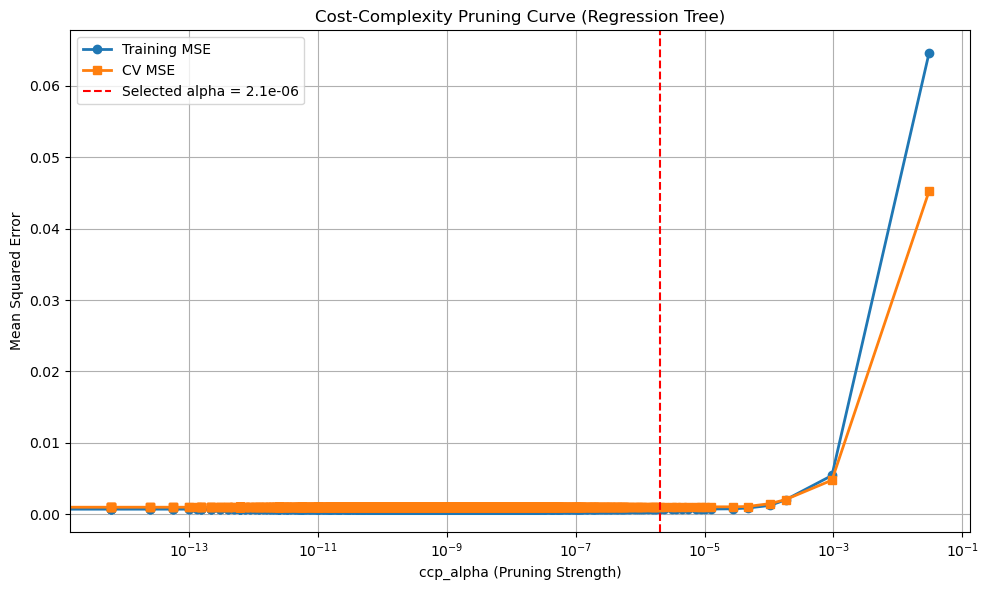

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_errors, label="Training MSE", marker='o', linewidth=2)
plt.plot(ccp_alphas, cv_errors, label="CV MSE", marker='s', linewidth=2)
plt.xlabel("ccp_alpha (Pruning Strength)")
plt.ylabel("Mean Squared Error")
plt.title("Cost-Complexity Pruning Curve (Regression Tree)")
plt.legend()
plt.grid(True)
plt.xscale('log')  # Optional: only if alpha values span orders of magnitude
plt.axvline(best_alpha, color='red', linestyle='--', label=f"Selected alpha = {best_alpha:.1e}")
plt.legend()
plt.tight_layout()
plt.show()

**Figure: Cost-Complexity Pruning Path for the Regression Tree**

This curve illustrates how training and block walk-forward cross-validation (CV) mean squared error (MSE) evolve as the pruning penalty (`ccp_alpha`) increases. 

- The **blue curve** shows training error, which naturally rises as the tree is pruned more aggressively.
- The **orange curve** shows block walk-forward CV error, which helps identify the pruning strength that balances bias and variance.
- The **red dashed line** indicates the selected `ccp_alpha` value (~2.1e-6), chosen to minimize CV error while maintaining a simpler tree.

This visualization confirms that the final pruned tree achieves stable generalization without unnecessary complexity.

## Closing Summary

In this notebook, we explored the use of **decision tree regression** to model short-term price behavior for XRP, a leading cryptocurrency, using carefully engineered lagged features and time-aware validation techniques.

Key steps included:
- Constructing lagged predictors to ensure a causal forecasting structure, avoiding future data leakage.
- Establishing a baseline tree model with a depth limit, then refining it using **cost-complexity pruning**.
- Applying **block walk-forward cross-validation** throughout to properly honor the sequential nature of the time series, providing realistic performance estimates.
- Visualizing the pruning path to select an optimal tree size that balances fit and generalization.

### Final Insights:
- The **baseline unpruned tree** showed excellent in-sample performance but benefited from pruning to reduce the risk of overfitting.
- The **pruned tree** achieved nearly identical performance on both a separate test set and under block walk-forward CV, confirming that simpler trees can generalize well in this context.
- This single decision tree now serves as a robust, interpretable benchmark for comparing more advanced models, such as Random Forests or boosted ensembles, in future work.

Together, these steps demonstrate that **transparent feature engineering, honest validation, and principled regularization** can yield trustworthy results, even with a straightforward tree-based approach.

---

**Next Steps:**  
In future notebooks, we will expand this framework by experimenting with ensemble methods, deeper temporal features, and more sophisticated time series techniques to push predictive accuracy even further.